# Binomial Lattice Pricing


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# DARK Monokai Theme for jupyter notebook
###################################################################################################
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')
# ####################################################################################################


* Stock trees can be represented using nodes (𝑖,𝑗)

* intial stock price $𝑆_0$


$$ S_{i,j} = S_{0}.u_j.d_i$$

WHERE,

> $C_{i,j}$ : represents option (European Call) price at each node (𝑖,𝑗).

> Where $𝐶_{𝑁,𝑗}$ represents final payoff function that we can define.

Simulating a European Call, so $𝐶_{𝑁,𝑗} =𝑚𝑎𝑥((𝑆_{𝑁,𝑗}−𝐾),0)$

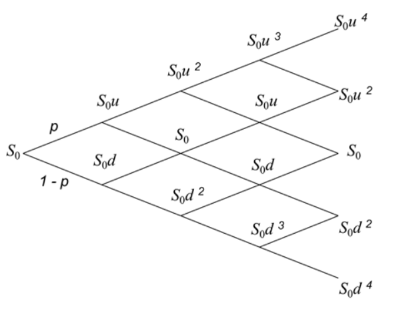

#### Initialise parameters

In [2]:
S = 100     #underlying
K = 102      #strike
T = 1         #Time to Expiry
r = 0.02       #risk free rate
steps = 15     #no. of steps
u = 1.05       #up factor : risk neutral prob of going up
d= 1/u        # risk neutral prob of going down
optionType = 'call'

#### Formulas

Discount Factor :    \
$$df= e^{-rt}$$

#### Risk Neutral Probabilities 

$$q= \frac{(e^{r\cdot d_t} - d)}{u-d}$$

#### Call option using Binomial Pricing

$$C = \frac{1}{e^{r\cdot t}}. \left[ q.C_u + (1-q).C_d  \right]$$

### Forward Price
$$forwardPrice = faceValue*\frac{forwardLattice_{0,0}}{zcbLattice_{0,0}}  $$

In [332]:
class Binomial_Pricing:
    """
    This Class has fucntions to price futures / spot/ options using Binomial Model
    """
    @staticmethod
    def print_lattice(lattice):
        for t, level in enumerate(lattice):
            
            level = [ round(elem, 3) for elem in level ]
            print (f'level {t} : ', (', '.join(map(str, level))))
    
    @staticmethod   
    def price_lattice( n=4,S0=100,u=1.25,d=0.9):
        """
        Binomial lattice /tree Spot prices  : Forward into the lattice (left -> right)
        :param n:     #no. of steps
        :param S0:   #starting point underlying
        :param u:       #up factor : risk neutral prob of going up
        :param d: 1/u        # risk neutral prob of going down
        
        Output example of params(n=4,S0=100,u=1.25,d=0.9):
        [
         [100.0],
         [90.0, 125.0],
         [81.0, 112.5, 156.25],
         [72.9, 101.25, 140.625, 195.3125],
         [65.61, 91.12500000000001, 126.56250000000001, 175.78125, 244.140625]
        ]

        
        """
        lattice = []
        for i in range(n+1):
            level = []
            for j in range(i+1):
                price = S0 * u**j * d**(i - j)
                level.append(price)
            lattice.append(level)
        return(lattice)
    
    @staticmethod   
    def future_lattice(n=4,S0=100,u=1.25,d=0.9, c=0.01, r=0.02):
        """
        Future's lattice from discounting of spot_lattice
        
        :param n:     #no. of steps
        :param S0:   #starting point underlying
        :param u:       #up factor : risk neutral prob of going up
        :param d: 1/u        # risk neutral prob of going down
        :param c:        # annual dividend rate
        :param r:      # risk free intererst rate
        """
        R = np.exp(r) #per step Rate 
        disc = 1/R
        #introduce dividend here
        q = (R-d-c)/(u-d)
        
        #spot lattice
        price_lattice = Binomial_Pricing.price_lattice(n,S0,u,d) 
        latticeLen =len(price_lattice)
        
        #futures lattice (right -> left)
        for i in range(latticeLen, -1, -1):
            print(i)
            print(price_lattice)
            if i == latticeLen:
                #introducing coupon here for the nth period/ Maturity
                print(price_lattice[i])
                price_lattice[i] = price_lattice[i, : (i + 1)] - c
            else:
                for j in range(i + 1):
                    childd = price_lattice[i + 1, j]
                    childu = price_lattice[i + 1, j + 1]
                    price_lattice[i, j] = q * childu + (1 - q) * childd
                    
        return(price_lattice)
    @staticmethod           
    def Option_Pricing_fast_(S, K, time, r, steps, u, d, optionType='call'):
        """
        pricing option using binomial model in a vectorized manner.
        
        :param S:   #underlying
        :param K:     #strike
        :param T:         #Time to Expiry
        :param r:       #risk free rate
        :param steps:     #no. of steps
        :param u:       #up factor : risk neutral prob of going up
        :param d: 1/u        # risk neutral prob of going down
        :param optionType: 'call'
        """
        
        
        #precompute constants
        dt = time/steps
        R= np.exp(r*dt)
        q = (R - d) / (u-d)
        disc = 1/R
        multiplier = 1 if optionType=='call' else -1  

        # we have tp go backwardds in lattice. SO, initialise asset prices at maturity - Time step N
        # hint: look at the lattic. s.d^4, s.d^3.u^1........
        Option_lattice = S * (d ** (np.arange(steps,-1,-1))) * (u ** (np.arange(0,steps+1,1))) 
        # initialise option values at maturity  as per 𝐶𝑁,𝑗=𝑚𝑎𝑥((𝑆𝑁,𝑗−𝐾),0)
        Option_lattice = np.maximum( multiplier*(Option_lattice - K), np.zeros(steps+1) )

        # step backwards through tree
        for i in np.arange(steps,0,-1):
            Option_lattice = disc * ( q * Option_lattice[1:i+1] + (1-q) * Option_lattice[0:i] )
        return Option_lattice[0]
    

    @staticmethod    
    def Option_Pricing_Slow(K,T,S0,r,steps,u,d,optionType='call'):
        """
        pricing option using binomial model in non vectorized but easy implementation
        
        The tree for a n period model is returned in the form of a matrix as - 
    
        
        :param K:     #strike
        :param T:         #Time to Expiry
        :param S0:   #starting point underlying
        :param r:       #risk free rate
        :param steps:     #no. of steps
        :param u:       #up factor : risk neutral prob of going up
        :param d: 1/u        # risk neutral prob of going down
        :param optionType: 'call'
        """
        
        #precompute constants
        dt = T/steps
        R = np.exp(r*dt)
        q = (R - d) / (u-d)
        disc = 1/R
        
        #call / put
        multiplier = 1 if optionType=='call' else -1  

        # initialise Spot prices at maturity - Time steps
        S = np.zeros(steps+1)
        S[0] = S0*d**steps
        for j in range(1,steps+1):
            S[j] = S[j-1]*u/d

        # initialise option values at maturity
        Option_lattice =  np.zeros(steps+1)
        for j in range(0,steps+1):
            Option_lattice[j] = max(0, multiplier*(S[j]-K))

        # step backwards through tree/lattice
        # hint: visualise this process for a usual lattice in Excel and going from Nth period to 1st (right to left)
        # and from bottom to top (nodes of that period) and reducing a node at a period. and thus getting Option Value
        for i in np.arange(steps,0,-1):
            for j in range(0,i):
                Option_lattice[j] = disc * ( q*Option_lattice[j+1] + (1-q)*Option_lattice[j] )
        opt_value = Option_lattice[0]
        return (opt_value)

    @staticmethod     
    def Option_american_Pricing_Slow(K,T,S0,r,steps,u,d,optionType='call', is_american=True):
        """
        pricing American option using binomial model in non vectorized but easy implementation
        
        The tree for a n period model is returned in the form of a matrix as - 
    
        
        :param K:     #strike
        :param T:         #Time to Expiry
        :param S0:   #starting point underlying
        :param r:       #risk free rate
        :param steps:     #no. of steps
        :param u:       #up factor : risk neutral prob of going up
        :param d: 1/u        # risk neutral prob of going down
        :param optionType: 'call'
        :param is_american: is option american or not
        """
        
        #precompute constants
        dt = T/steps
        R = np.exp(r*dt)
        q = (R - d) / (u-d)
        disc = 1/R
        
        #call / put
        multiplier = 1 if optionType=='call' else -1  

        # initialise Spot prices at maturity - Time steps
        S = np.zeros(steps+1)
        S[0] = S0*d**steps
        for j in range(1,steps+1):
            S[j] = S[j-1]*u/d

        # initialise option values at maturity
        Option_lattice =  np.zeros(steps+1)
        for j in range(0,steps+1):
            Option_lattice[j] = max(0, multiplier*(S[j]-K))

        # step backwards through tree/lattice
        # hint: visualise this process for a usual lattice in Excel and going from Nth period to 1st (right to left)
        # and from bottom to top (nodes of that period) and reducing a node at a period. and thus getting Option Value
        for i in np.arange(steps,0,-1):
            for j in range(0,i):
                earlyExercise =  max(0, multiplier*(S[j]-K))
                hold =  disc * ( q*Option_lattice[j+1] + (1-q)*Option_lattice[j] )
                if earlyExercise > hold and isAmerican:
                    print (f"At time {n-i-1}, it's better to early exercise {earlyExercise} than hold {hold}")
                Option_lattice[j] = disc * ( q*Option_lattice[j+1] + (1-q)*Option_lattice[j] )
        opt_value = Option_lattice[0]
        return (opt_value)
    
    
    @staticmethod
    def OptionLattice( n=4, q=0.5, K=100, isCall=True, isAmerican=False, rateLattice=[], baseLattice=[]):
        """
        Option Binomial pricing for bonds / or any prices
        """
        
        
        multiplier = 1 if isCall else -1
        clippedBase = baseLattice[:n+1]
        clippedRate = rateLattice[:n+1]
        lattice = []
        rightLevel = []
        
        for i, level in enumerate(reversed(clippedBase)):
            newLevel = []
            if i == 0:
                for j in range(len(level)):
                    newLevel.append(max(multiplier * (level[j]-K), 0))
            else:
                for j in range(len(level)):
                    earlyExercise = max(multiplier * (level[j]-K), 0)
                    discount = 1.+clippedRate[n-i][j]
                    hold = (q*rightLevel[j+1] + (1-q)*rightLevel[j])/discount
                    if earlyExercise > hold and isAmerican:
                        print ("At time {0}, it's better to early exercise {1} than hold {2}".format(n-i, earlyExercise, hold))        
                    newPrice = max(hold, earlyExercise) if isAmerican else hold
                    newLevel.append(newPrice)
            rightLevel = newLevel
            lattice.insert(0, newLevel)
        return(lattice)
    
    
    @staticmethod 
    def rate_lattice( n =4, rate = 0.06, u=1.25, d=0.9):
        """
        Rate lattice and Price lattice are exactly same
        
        Build a interest rate lattice based on upper and lower movements in rates going forward in lattice
        :param n: number of lattice periods
        :param rate: initial rate rate_0,0
        :param u:  rate_1,1 = u*rate_0,0
        :param d:  rate_1,0 = d*rate_0,0
        
        OUTPUT example for  params (n =4, rate = 0.06, u=1.25, d=0.9) :
        [
         [0.06],
         [0.054, 0.075],
         [0.048600000000000004, 0.0675, 0.09375],
         [0.04374, 0.06075, 0.084375, 0.1171875],
         [0.039366, 0.05467500000000001, 0.0759375, 0.10546875, 0.146484375]
        ]
        
        """
        S0 =rate
        lattice = []
        for i in range(n+1):
            level = []
            for j in range(i+1):
                new_rate = S0 * u**j * d**(i - j)
                level.append(new_rate)
            lattice.append(level)
        return(lattice)
    
    @staticmethod
    def ZeroCouponBond_lattice( face_value=100, q=0.5, n=4,  base_RateLattice=[]):
        """
        Lattice for ZCB
        :param  face_value: face value of the bond
        :param  q: risk neutral pricing
        :param  n: number of periods
        :patam base_RateLattice: rate lattice for the ZCB
    
      
        OUTPUT FOR PARAM(face_value=100, q=0.5, n=4,u=1.1, d=0.9, rate = 0.06):
        [[79.2348102355995],
         [85.41297237052876, 82.56482532894219],
         [90.9472606145058, 89.10328514256885, 86.92492245873592],
         [95.80930116695728, 94.92529379378429, 93.86674676629058, 92.60459689218972],
         [100, 100, 100, 100, 100]]
        
        """
        
        lattice = []

        clippedRate =base_RateLattice[:n+1]
        rightLevel = []
        
        for i, level in enumerate(reversed(clippedRate)):
            newLevel = []
            if i == 0:
                for j in range(len(level)):
                    newLevel.append(face_value)
            else:
                for j in range(len(level)):
                    discount = 1.+ (clippedRate[n-i][j])
                    price = (q*rightLevel[j+1]+(1-q)*rightLevel[j])/discount
                    newLevel.append(price)
            rightLevel = newLevel
            lattice.insert(0, newLevel)
        return(lattice)
    
    @staticmethod
    def CouponBond_lattice(face_value=100, q=0.5, c=0.02, n=4, base_RateLattice=[0]):
        """
        Coupon bearing bond lattice
        
        :param face_value: face vale of the bond
        :param q: risk neutral pricing
        :param n: periods
        :param c: coupon percent 
        :patam base_RateLattice: rate lattice for the   Coupon bearing bond 
        
        OUTPUT for params (face_value=100, q=0.5, n=4, c=0.02, u=1.1, d=0.9, rate = 0.06) : 
        level 0 :  88.166
        level 1 :  92.819, 89.852
        level 2 :  96.674, 94.773, 92.528
        level 3 :  99.725, 98.824, 97.744, 96.457
        level 4 :  102.0, 102.0, 102.0, 102.0, 102.0
        
        """
        lattice = []
        
        #coupon value 
        coupon = face_value*c
        
        #rate_lattice :NOTE: it should be in decimal
        clippedRate = base_RateLattice[:n+1]
        
        for i, level in enumerate(reversed(clippedRate)):
            newLevel = []
            
            #initialising right-most level (maturity)
            if i == 0: 
                for j in range(len(level)):
                    newLevel.append(face_value+coupon)
            #remaining lattices values
            else:
                for j in range(len(level)):
                    spotRate = clippedRate[n-i][j]
                    disc_factor = (1+spotRate)
                    #NOTE : coupon is not to be discounted
                    #BondPrice = coupon + (1/R)*( q*rj1 + (1-q)*rj0)
                    price = coupon + ((1/disc_factor) * (q*rightLevel[j+1]+(1-q)*rightLevel[j]))
                    newLevel.append(price)
            rightLevel = newLevel
            #pushing the newLevel at first position
            lattice.insert(0, newLevel)
        return(lattice)
    
    @staticmethod
    def forward_lattice( face_value=100, q=0.5, c=0.10, n=4,base_RateLattice=[0],base_couponBond=[0] ):
        """
        Forward lattice for forward of the coupon bearing bond pricing
        """
        lattice = []
        coupon = face_value*c
        #rate_lattice :NOTE: it should be in decimal
        clippedRate = base_RateLattice[:n+1]
        clippedBase = base_couponBond[:n+1]     

        for i, level in enumerate(reversed(clippedBase)):
            newLevel = []
            
            # maturity case
            if i == 0:
                for j in range(len(level)):
                    #removing coupon which was priced in the bond
                    bondPrice = clippedBase[n-i][j]
                    price = bondPrice - coupon
                    newLevel.append(price)
                    
            # non maturity, in between cases
            else:
                for j in range(len(level)):
                    spotRate = clippedRate[n-i][j]
                    disc_factor = 1/(1+spotRate)
                    #BondPrice = (1/R)*( q*rj1 + (1-q)*rj0)
                    price = (disc_factor)*(q*rightLevel[j+1]+(1-q)*rightLevel[j])
                    newLevel.append(price)
            rightLevel = newLevel
            lattice.insert(0, newLevel)
        return(lattice)
    
    @staticmethod
    def future_lattice(face_value=100, q=0.5, c=0.10, n=4,base_couponBond=[0]):
        """
        Futures lattice of a coupon bearing bond
        """
        lattice = []
        coupon = face_value*c
        
        clippedBase = base_couponBond[:n+1]      
        for i, level in enumerate(reversed(clippedBase)):
            newLevel = []
            
             # maturity case
            if i == 0:
                for j in range(len(level)):
                    bondPrice = clippedBase[n-i][j]
                    price = bondPrice - coupon
                    newLevel.append(price)
                    
             # non maturity, in between cases
            else:
                for j in range(len(level)):
                    #No discounting happening
                    price = q*rightLevel[j+1]+(1-q)*rightLevel[j]
                    newLevel.append(price)
            rightLevel = newLevel
            lattice.insert(0, newLevel)
        return(lattice)
    
    
       
    
    @staticmethod
    def swap_lattice( q=0.05, n=6, fixed_rate=0.05, firstPaymentTime=1, payFixed=True, base_RateLattice=[0]):
        """
        SWAP pricing model
        
        :param firstPaymentTime: first payment time of the swap
        :param payFixed: boolean, if the payment is fixed or floating
        :para fixed_rate:  fixed_rate
        """
        clippedRate = base_RateLattice[:n+1]
        lattice = []
        rightLevel = []
        
        for i, level in enumerate(reversed(clippedRate)):
            newLevel = []
            if i == 0:
                #positive payment means, we're receive floating - fixed from a swap receiver, else we're loosing that amount 
                #cash flow for swap seller is floating - fixed, and opposite for swap buyer
                for j in range(len(level)):
                    
                    spotRate = clippedRate[n-i][j]
                    payment = spotRate-fixed_rate if payFixed else fixed_rate-spotRate
                    newPrice = payment/(1+spotRate)
                    newLevel.append(newPrice)
            else:
                for j in range(len(level)):
                    spotRate = clippedRate[n-i][j]
                    newPrice = (q*rightLevel[j+1]+(1-q)*rightLevel[j])/(1.+spotRate)
                    if n-i >= firstPaymentTime: #NOTE
                        payment = spotRate-fixed_rate if payFixed else fixed_rate-spotRate 
                        newPrice += payment/(1 + spotRate)
                    newLevel.append(newPrice)
            rightLevel = newLevel
            lattice.insert(0, newLevel)
            
        return(lattice)

In [333]:
# Binomial_Pricing.rate_lattice(period =4, S0 = 0.06, u=1.25, d=0.9)


### example of 1 period binomial lattice explicitely

Consider a 1-period binomial model with rate of interest as 2%,  $S_0$= 100$, u = 1/d = 1.05.

Compute the value of a European call option on the stock with strike K=102. The stock does not pay dividends.

In [334]:
S0 = 100
u = 1.05
d = 1 / u
R = 1.02
K = 102

Cu = max(S0 * u - K, 0)
Cd = max(S0 * d - K, 0)
q = (R - d) / (u - d)
C0 = (q * Cu + (1 - q) * Cd) / R
round(C0, 2)

2.04

In [335]:
#similar result usi//ng mult Period binomial option pricing Model
Binomial_Pricing.Option_Pricing_fast_(S, K, T, r, steps, u, d, optionType='call')

7.617497887869135

### Binomial pricing for rates , zero-coupon bonds, forwards , futures, Coupon bearing bonds, etc. 

In [336]:
# parameters 
n = 10
rate= 0.05
u = 1.1
d = 0.9
face_value =100
q=0.5
c=0.0

In [337]:
rateL= Binomial_Pricing.rate_lattice(n, rate, u, d)
Binomial_Pricing.print_lattice(rateL)

level 0 :  0.05
level 1 :  0.045, 0.055
level 2 :  0.041, 0.05, 0.061
level 3 :  0.036, 0.045, 0.054, 0.067
level 4 :  0.033, 0.04, 0.049, 0.06, 0.073
level 5 :  0.03, 0.036, 0.044, 0.054, 0.066, 0.081
level 6 :  0.027, 0.032, 0.04, 0.049, 0.059, 0.072, 0.089
level 7 :  0.024, 0.029, 0.036, 0.044, 0.053, 0.065, 0.08, 0.097
level 8 :  0.022, 0.026, 0.032, 0.039, 0.048, 0.059, 0.072, 0.088, 0.107
level 9 :  0.019, 0.024, 0.029, 0.035, 0.043, 0.053, 0.065, 0.079, 0.096, 0.118
level 10 :  0.017, 0.021, 0.026, 0.032, 0.039, 0.048, 0.058, 0.071, 0.087, 0.106, 0.13


In [338]:
priceL= Binomial_Pricing.price_lattice(n, rate, u, d)
Binomial_Pricing.print_lattice(priceL)

level 0 :  0.05
level 1 :  0.045, 0.055
level 2 :  0.041, 0.05, 0.061
level 3 :  0.036, 0.045, 0.054, 0.067
level 4 :  0.033, 0.04, 0.049, 0.06, 0.073
level 5 :  0.03, 0.036, 0.044, 0.054, 0.066, 0.081
level 6 :  0.027, 0.032, 0.04, 0.049, 0.059, 0.072, 0.089
level 7 :  0.024, 0.029, 0.036, 0.044, 0.053, 0.065, 0.08, 0.097
level 8 :  0.022, 0.026, 0.032, 0.039, 0.048, 0.059, 0.072, 0.088, 0.107
level 9 :  0.019, 0.024, 0.029, 0.035, 0.043, 0.053, 0.065, 0.079, 0.096, 0.118
level 10 :  0.017, 0.021, 0.026, 0.032, 0.039, 0.048, 0.058, 0.071, 0.087, 0.106, 0.13


In [339]:
zcbL = Binomial_Pricing.ZeroCouponBond_lattice( face_value, q, n, base_RateLattice =rateL )
Binomial_Pricing.print_lattice(zcbL)

level 0 :  61.622
level 1 :  67.441, 61.965
level 2 :  72.882, 68.07, 62.676
level 3 :  77.887, 73.78, 69.099, 63.838
level 4 :  82.422, 79.029, 75.105, 70.617, 65.556
level 5 :  86.475, 83.778, 80.619, 76.952, 72.741, 67.969
level 6 :  90.047, 88.008, 85.594, 82.755, 79.445, 75.623, 71.261
level 7 :  93.158, 91.723, 90.009, 87.973, 85.567, 82.745, 79.462, 75.683
level 8 :  95.831, 94.94, 93.868, 92.582, 91.046, 89.221, 87.063, 84.531, 81.584
level 9 :  98.1, 97.687, 97.188, 96.584, 95.856, 94.982, 93.934, 92.685, 91.202, 89.454
level 10 :  100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100


In [340]:
cbL = Binomial_Pricing.CouponBond_lattice(face_value, q,  c, n, base_RateLattice =rateL)
Binomial_Pricing.print_lattice(cbL)

level 0 :  61.622
level 1 :  67.441, 61.965
level 2 :  72.882, 68.07, 62.676
level 3 :  77.887, 73.78, 69.099, 63.838
level 4 :  82.422, 79.029, 75.105, 70.617, 65.556
level 5 :  86.475, 83.778, 80.619, 76.952, 72.741, 67.969
level 6 :  90.047, 88.008, 85.594, 82.755, 79.445, 75.623, 71.261
level 7 :  93.158, 91.723, 90.009, 87.973, 85.567, 82.745, 79.462, 75.683
level 8 :  95.831, 94.94, 93.868, 92.582, 91.046, 89.221, 87.063, 84.531, 81.584
level 9 :  98.1, 97.687, 97.188, 96.584, 95.856, 94.982, 93.934, 92.685, 91.202, 89.454
level 10 :  100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0


In [341]:
forwardL = Binomial_Pricing.forward_lattice(face_value, q,  c=0, n=4,base_RateLattice =rateL, base_couponBond=cbL)
Binomial_Pricing.print_lattice(forwardL)

print("forward_price: ", face_value*forwardL[0][0]/zcbL[0][0])

level 0 :  61.622
level 1 :  67.441, 61.965
level 2 :  72.882, 68.07, 62.676
level 3 :  77.887, 73.78, 69.099, 63.838
level 4 :  82.422, 79.029, 75.105, 70.617, 65.556
forward_price:  100.00000000000003


In [342]:
futureL = Binomial_Pricing.future_lattice(face_value, q,  c, n=4,base_couponBond =cbL)
Binomial_Pricing.print_lattice(futureL)

level 0 :  74.825
level 1 :  76.93, 72.719
level 2 :  78.896, 74.964, 70.474
level 3 :  80.726, 77.067, 72.861, 68.087
level 4 :  82.422, 79.029, 75.105, 70.617, 65.556


### Swap Pricing

In [298]:
fixedRate = .05
firstPaymentTime = 1
paysFixed = True
n=10
swapL = Binomial_Pricing.swap_lattice(q, n, fixedRate, firstPaymentTime, paysFixed, base_RateLattice=rateL)         
Binomial_Pricing.print_lattice(swapL)

level 0 :  -0.003
level 1 :  -0.042, 0.035
level 2 :  -0.072, -0.006, 0.069
level 3 :  -0.093, -0.037, 0.027, 0.098
level 4 :  -0.107, -0.06, -0.007, 0.054, 0.122
level 5 :  -0.111, -0.074, -0.031, 0.019, 0.076, 0.14
level 6 :  -0.108, -0.08, -0.046, -0.007, 0.039, 0.091, 0.15
level 7 :  -0.098, -0.077, -0.052, -0.023, 0.012, 0.052, 0.098, 0.151
level 8 :  -0.082, -0.068, -0.05, -0.03, -0.005, 0.023, 0.057, 0.096, 0.14
level 9 :  -0.06, -0.051, -0.04, -0.028, -0.013, 0.005, 0.027, 0.052, 0.081, 0.115
level 10 :  -0.032, -0.028, -0.023, -0.018, -0.011, -0.002, 0.008, 0.02, 0.034, 0.051, 0.071


### OptionLattice

In [343]:
K = 80
n=6
# zcbL = Binomial_Pricing.ZeroCouponBond_lattice( face_value, q, n=10, base_RateLattice =rateL )

optL =Binomial_Pricing.OptionLattice( n, q, K, isCall=True, isAmerican=True, rateLattice=rateL, baseLattice=zcbL)     
Binomial_Pricing.print_lattice(optL)

level 0 :  2.357
level 1 :  3.394, 1.557
level 2 :  4.647, 2.445, 0.839
level 3 :  6.03, 3.641, 1.491, 0.289
level 4 :  7.423, 5.077, 2.529, 0.617, 0.0
level 5 :  8.769, 6.564, 3.998, 1.307, 0.0, 0.0
level 6 :  10.047, 8.008, 5.594, 2.755, 0, 0, 0


### Option Replication Equations:



$$ u\cdot {S_0}\cdot x + R\cdot y = {C_u}$$
$$ d\cdot {S_0}\cdot x + R\cdot y = {C_d}$$

In [101]:
S0 = 100
u=1.05
d= 1/u
Cu = 3
Cd = 0

R=1.02

x_s0 = (Cu - Cd) / (u - d)
x= x_s0/S0
y = (Cu - x_s0 * u) / R

print(f"options:{x:.3f}, cash: {y:.3f} ")


options:0.307, cash: -28.694 


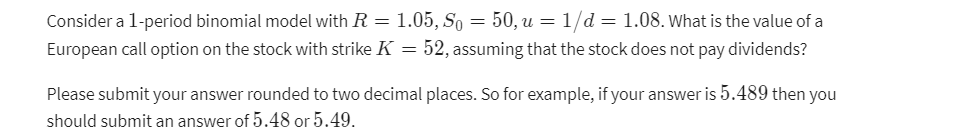

In [102]:
S0 = 50
u = 1.08
d = 1 / u
R = 1.05
K = 52

Cu = max(S0 * u - K, 0)
Cd = max(S0 * d - K, 0)
q = (R - d) / (u - d)
C0 = (q * Cu + (1 - q) * Cd) / R
round(C0, 2)

1.53

## Replicating Strategy for Option Pricing

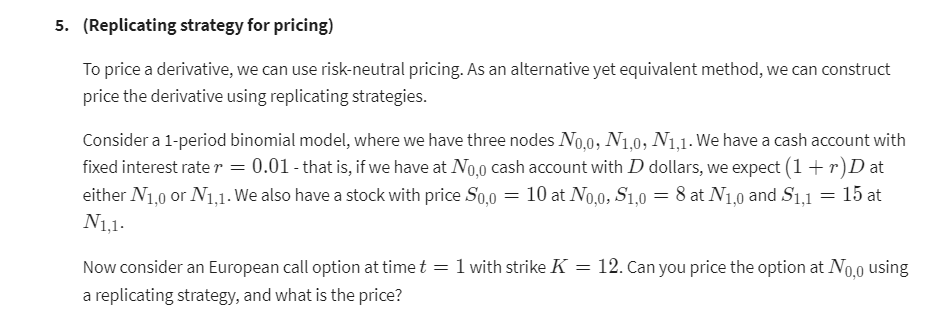

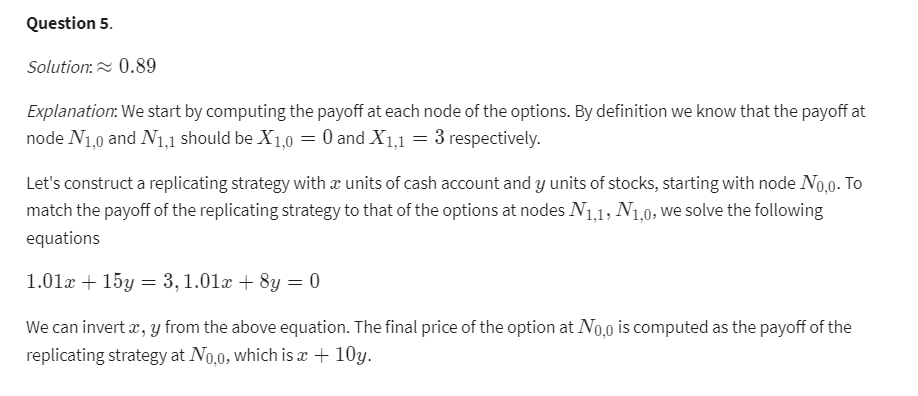